## From classical to neural potentials

This document introduces graph neural network models for atomistic properties by building up from classical interatomic potentials
Interatomic potentials model the energy of a system of atoms as a function of the atomic species and coordinates.

See https://arxiv.org/abs/2204.09563 for a comprehensive overview.


Classical potentials expand the total energy $U(\{\mathbf{r}\})$ into additive contributions for pairs, triplets, and higher order cliques of atoms:

$$
U(\{\mathbf{r}\}) = \sum_i \phi_1(\mathbf{r}_i)  
+ \sum_i \sum_j \phi_2(\mathbf{r}_i, \mathbf{r}_j) 
+ \sum_i \sum_j \sum_k \phi_3(\mathbf{r}_i, \mathbf{r}_j, \mathbf{r}_k)
+ \ldots
$$

where $\{\mathbf{r}\}$ is the set of all atomic coordinates $\mathbf{r}_i$, and $\phi_1$, $\phi_2$, $\phi_3$, etc are unary, pair, and triplet interaction functions. (In general, these functions are also species-dependent, but we'll ignore that to keep the notation simple.)

In classical interatomic potentials, the functions $\phi$ are generally based on a physically-motivated functional form, while in machine learning (ML) potentials they are implemented by neural networks, Gaussian processes, or similar.

Let's start with a simple pair potential and build up our understanding!

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

import ase
from ase.build import fcc111
from ase.visualize.plot import plot_atoms

import torch

## Lennard Jones pair potential
Consider a simple unary system: a 2D hexagonal lattice of Ne atoms.
Noble gases like this are often modeled with a simple pair potential - the Lennard Jones potential

$$
\begin{align}
U(\{\mathbf{r}\}) &= \sum_i \sum_j \phi_{LJ}(r_{ij}) \\
\phi_{LJ}(r) &= 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]
\end{align}
$$

where $r_{ij} = ||\mathbf{r}_i - \mathbf{r}_j||^2$ is the bond length between atoms $i$ and $j$.



In [2]:
def lj(r, sigma=1.0, epsilon=1.0):
    """Lennand Jones pair interaction."""
    c6 = (sigma / r) ** 6
    c12 = c6 ** 2
    return 4 * epsilon * (c12 - c6)

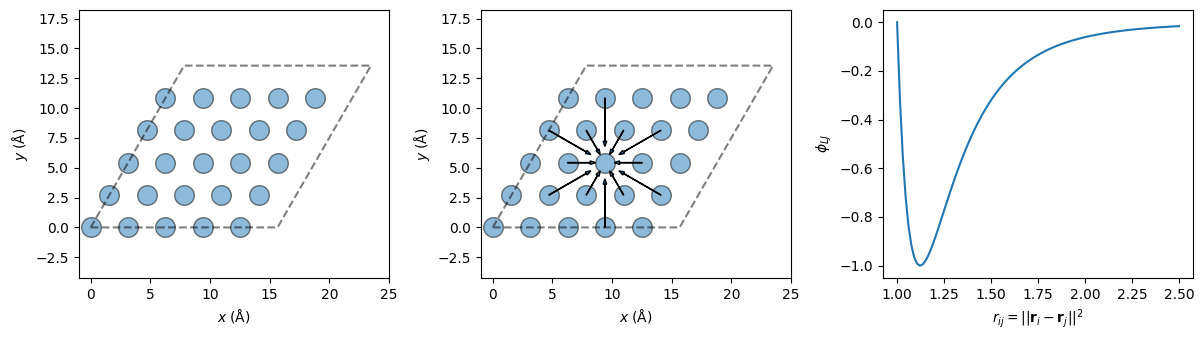

In [17]:
from ase.lattice.cubic import FaceCenteredCubic
slab = fcc111('Ne', size=(5,5,1), vacuum=10.0)
x, y, z = slab.get_positions().T

def draw_cell(atoms, ax):
    """Draw cell oriented along [0 0 1] direction."""
    corners = np.stack([
        (atoms.get_scaled_positions()[0] + offset @ atoms.cell.array)[:2]
        for offset in [[0,0,0], [1,0,0], [1, 1, 0], [0,1,0], [0,0,0]]
    ])
    ax.plot(corners[:,0], corners[:,1], linestyle="--", color="k", alpha=0.5)
    ax.set_xlabel(r"$x\;(\mathrm{\AA})$")
    ax.set_ylabel(r"$y\;(\mathrm{\AA})$");
    return

fig, axes = plt.subplots(ncols=3, figsize=(12,3.5))

for ax in axes[:2]:
    ax.scatter(x, y, s=200, edgecolors="k", alpha=0.5)
    draw_cell(slab, ax)

    ax.axis("equal")
    ax.set(xlim=(-1, 25), ylim=(-1, 15))


i = 12
nbrs = [7, 8, 11, 13, 16, 17]
nbrs += [3, 6, 9, 15, 18, 21]
f = 0.75
for nbr in nbrs:
    ax.arrow(
        x[nbr], y[nbr], f*(x[i]-x[nbr]), f*(y[i]-y[nbr]), 
        width=0.025, head_width=0.3, length_includes_head=True
    )

ax = axes[-1]
rs = np.linspace(1, 2.5, 100)
ax.plot(rs, lj(rs))
ax.set(xlabel=r"$r_{ij} = ||\mathbf{r}_i - \mathbf{r}_j||^2$", ylabel=r"$\phi_{LJ}{(r)$")


plt.tight_layout()

Implementing this in pytorch is straightforward: `periodic_radius_graph` constructs a graph representation of all pairs of atoms:



In [4]:
from nfflr.data.atoms import Atoms
from nfflr.data.graph import periodic_radius_graph

g = periodic_radius_graph(Atoms(slab), r=cutoff)
g

Graph(num_nodes=25, num_edges=150,
      ndata_schemes={'Xfrac': Scheme(shape=(3,), dtype=torch.float32), 'coord': Scheme(shape=(3,), dtype=torch.float32), 'atomic_number': Scheme(shape=(), dtype=torch.int32)}
      edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)})

Since the graph construction function stores relative position vectors  $\mathbf{r}_{ij} = \mathbf{r}_j - \mathbf{r}_i$ as edge attributes `g.edata["r"]`, we don't actually need to do any graph computation. 
We can just call our implementation of $\phi_{LJ}$ and sum the contributions from each bond to obtain the total energy.

Alternatively, skip the periodic boundary conditions to keep things simple:

In [27]:
import dgl
import dgl.function as fn
cutoff = 4
r = torch.from_numpy(slab.get_positions())
g = dgl.radius_graph(r, cutoff)
g.ndata["r"] = r


In [7]:
lj(torch.norm(g.edata["r"], dim=1)).sum()

tensor(-0.6344)

In [33]:
def lj_kernel(edges):
    # compute relative position vector -> bond length
    r_ij = (edges.dst["r"] - edges.src["r"]).norm(dim=1)
    return {"phi_ij": lj(r_ij)}

g.update_all(lj_kernel, fn.sum("phi_ij", "energy_i"))
g.ndata["energy_i"]

tensor([-0.0085, -0.0169, -0.0169, -0.0169, -0.0127, -0.0169, -0.0254, -0.0254,
        -0.0254, -0.0169, -0.0169, -0.0254, -0.0254, -0.0254, -0.0169, -0.0169,
        -0.0254, -0.0254, -0.0254, -0.0169, -0.0127, -0.0169, -0.0169, -0.0169,
        -0.0085], dtype=torch.float64)

The [full implementation](https://github.com/usnistgov/nfflr/blob/3455de156d66f2ee58481c426ca2033f331fc864/nfflr/models/classical/lj.py#L118) also uses automatic differentiation to compute the atomic forces.

## Embedded atom model

The Lennard Jones model can reproduce many of the behaviors of ideal gases, but it is not particularly useful for modeling solids.
Let's take a look at the Embedded Atom Method, which is a widely used model for metallic systems.

The energy is decomposed into pairwise $\phi_2$ terms and an embedding function $F(\rho)$ of the electron density $\rho_i$ around each atom $i$.

$$
\begin{align}
U(\{\mathbf{r}\}) &= \sum_i \sum_j \phi_2(r_{ij}) + \sum_i F(\rho_i)\\
\end{align}
$$

The estimate of the local electron densities $\rho_i$ are themselves modeled as a pairwise expansion

$$
\rho_i = \sum_{j \neq i} f(r_{ij})
$$

Typically, the pair potential $\phi_2$, the density function $f$, and the embedding function $F$ are cubic splines.
[Early EAM work](https://dx.doi.org/10.1103/physrevb.33.7983) parameterized the density function $f$ in terms of *ab initio* calculations of the atomic densities, but sometimes more recent EAM style potentials are fully empirical.

In [244]:
!curl https://www.ctcms.nist.gov/potentials/Download/1999--Mishin-Y-Farkas-D-Mehl-M-J-Papaconstantopoulos-D-A--Al/2/Al99.eam.alloy -o Al99.eam.alloy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  762k  100  762k    0     0  3818k      0 --:--:-- --:--:-- --:--:-- 3888k


In [8]:
from nfflr.models.classical.eam import TorchEAM
eam = TorchEAM("Al99.eam.alloy")

# fig, axes = plt.subplots(nrows=3)

# axes[0].plot(eam.data.rs, eam.data.rphi_data / eam.data.rs)
# axes[0].set(xlabel=r"$r_{ij}$", ylabel=r"$\phi_2(r_{ij})$")
# axes[1].plot(eam.data.rs, eam.data.density_data)
# axes[1].set(xlabel=r"$r_{ij}$", ylabel=r"$f(r_{ij})$")
# axes[2].plot(eam.data.rhos, eam.data.embedded_data)
# axes[2].set(xlabel=r"$\rho$", ylabel=r"$F(\rho)$")
# plt.tight_layout()

The pair potential term $\phi_2$ can be implemented using the same approach as with the Lennard Jones model.
The local density computation is more interesting because we can use graph message passing to implement it:

In [34]:
slab = fcc111('Au', size=(20,20,1), vacuum=10.0)
slab.rattle(stdev=0.12)
x, y, z = slab.get_positions().T

r = torch.from_numpy(slab.get_positions())
g = dgl.radius_graph(r, eam.data.cutoff)
g.ndata["r"] = r

# g = periodic_radius_graph(Atoms(slab), r=eam.data.cutoff)

g

Graph(num_nodes=400, num_edges=6420,
      ndata_schemes={'r': Scheme(shape=(3,), dtype=torch.float64)}
      edata_schemes={})

First, compute the bond lengths and evaluate the pair potential spline $\phi_2$ and the local density contribution spline $f$:

In [43]:
g.apply_edges(fn.v_sub_u("r", "r", "r_ij"))
bondlength = g.edata["r_ij"].norm(dim=1)

/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In [10]:
bondlength = g.edata["r"].norm(dim=1)
rho_ij, rphi = eam.radial_spline.evaluate(bondlength).split(1, dim=1)

Next, aggregate the local density contributions over neighborhoods to obtain $\rho_i = \sum_{j \neq i} f(r_{ij})$

In [11]:
import dgl.function as fn
g.edata["rho_ij"] = rho_ij
g.update_all(fn.copy_e("rho_ij", "m"), fn.sum("m", "rho"))
rho = g.ndata.pop("rho")

/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


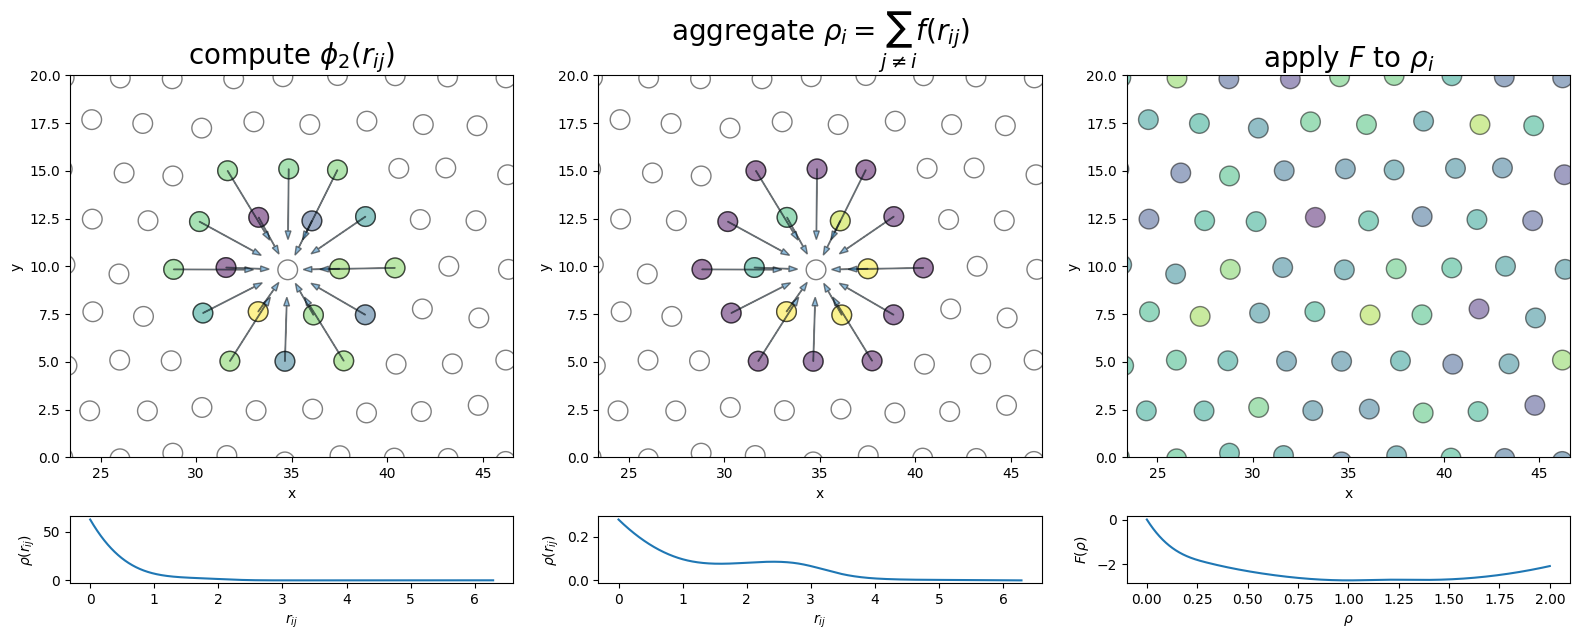

In [12]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16,6.5))
gs = GridSpec(9, 9, figure=fig)
ax1 = fig.add_subplot(gs[:7,:3])
ax2 = fig.add_subplot(gs[7:,:3])

ax3 = fig.add_subplot(gs[:7,3:6])
ax4 = fig.add_subplot(gs[7:,3:6])

ax5 = fig.add_subplot(gs[:7,6:])
ax6 = fig.add_subplot(gs[7:,6:])

# highlight a specific atom i and its neighborhood
# i = 70
i = 90
src, dst = g.all_edges()
nbrs = dst == i

# plot the pair potential
ax = ax1
ax.scatter(x, y, s=200, edgecolors="k", alpha=0.5, color="none")
ax.scatter(x[src[nbrs]], y[src[nbrs]], s=200, edgecolors="k", alpha=0.5, c=(rphi.squeeze() / bondlength)[nbrs])
ax.axis("equal")
ax.set(xlabel="x", ylabel="y")
ax.set(xlim=(25, 45), ylim=(0, 20))

f = 0.7
for nbr in src[nbrs]:
    ax.arrow(
        x[nbr], y[nbr], f*(x[i]-x[nbr]), f*(y[i]-y[nbr]), 
        width=0.025, head_width=0.3, length_includes_head=True, alpha=0.5
    )

ax2.plot(eam.data.rs, eam.data.rphi_data / eam.data.rs)
ax2.set(xlabel=r"$r_{ij}$", ylabel=r"$\rho(r_{ij})$")

# plot the local density function
ax = ax3
ax.scatter(x, y, s=200, edgecolors="k", alpha=0.5, color="none")
ax.scatter(x[src[nbrs]], y[src[nbrs]], s=200, edgecolors="k", alpha=0.5, c=rho_ij[nbrs])
# draw_cell(slab, ax)
ax.axis("equal")
ax.set(xlabel="x", ylabel="y")
ax.set(xlim=(25, 45), ylim=(0, 20))

f = 0.7
for nbr in src[nbrs]:
    ax.arrow(
        x[nbr], y[nbr], f*(x[i]-x[nbr]), f*(y[i]-y[nbr]), 
        width=0.025, head_width=0.3, length_includes_head=True, alpha=0.5
    )

ax4.plot(eam.data.rs, eam.data.density_data)
ax4.set(xlabel=r"$r_{ij}$", ylabel=r"$\rho(r_{ij})$")

# draw the aggregated density \rho
ax = ax5
ax.scatter(x, y, s=200, edgecolors="k", alpha=0.5, c=rho)
ax.axis("equal")
ax.set(xlabel="x", ylabel="y")
ax.set(xlim=(25, 45), ylim=(0, 20))

ax6.plot(eam.data.rhos, eam.data.embedded_data)
ax6.set(xlabel=r"$\rho$", ylabel=r"$F(\rho)$")


ax1.set_title(r"compute $\phi_2(r_{ij})$", size=20)
ax3.set_title(r"aggregate $\rho_i = \sum_{j \neq i} f(r_{ij})$", size=20)
ax5.set_title(r"apply $F$ to $\rho_i$", size=20)
plt.tight_layout()


### Aside: Multicomponent EAM
Multicomponent potentials typically have explicit cross-species parameters - for example this quinary AlCrFeCoNi EAM potential has five embedding functions $F_s$, five density functions $\rho_s$, and 15 pair terms $\phi_{2,s}$:

In [268]:
! curl https://www.ctcms.nist.gov/potentials/Download/2020--Farkas-D-Caro-A--Fe-Ni-Cr-Co-Al/1/FeNiCrCoAl-heaweight.setfl -o FeNiCrCoAl-heaweight.setfl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1791k  100 1791k    0     0  6560k      0 --:--:-- --:--:-- --:--:-- 6634k


In [364]:
import re
from collections import defaultdict
def load_cantor():

    Nrho = 2000
    drho = 0.1000500250125062E-02
    rhos = torch.tensor(drho * np.arange(Nrho))

    Nr = 3000
    dr = 0.1935228409469823E-02
    rs = torch.tensor(dr * np.arange(Nr))

    data = defaultdict(list)
    header = True
    with open("FeNiCrCoAl-heaweight.setfl", "r") as f:
        for line in f:
            if re.search("fcc$", line.strip()):
                header = False
                key = int(line.strip().split()[0])
                continue

            elif header:
                continue
            
            else:
                data[key] += list(map(float, line.strip().split()))

    # last component has all the pair potentials concatenated on
    k = list(data.keys())[-1]
    phi_data = torch.tensor(data[k][Nrho + Nr : ])
    data[k] = data[k][:Nrho + Nr]

    return rs, rhos, data, phi_data, 

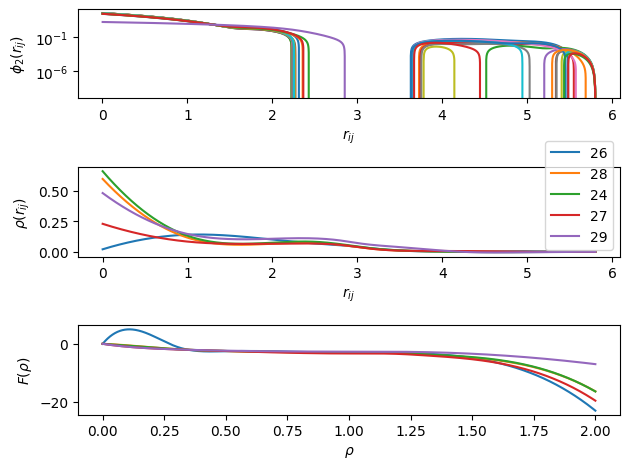

In [381]:
rs, rhos, data, phi_data = load_cantor()

fig, axes = plt.subplots(nrows=3)

for phi in phi_data.split(len(rs)):
    axes[0].plot(rs, phi / rs)

axes[0].set(xlabel=r"$r_{ij}$", ylabel=r"$\phi_2(r_{ij})$")
axes[0].semilogy()

for k, v in data.items():
    axes[1].plot(rs, v[len(rhos):], label=k)
axes[1].set(xlabel=r"$r_{ij}$", ylabel=r"$\rho(r_{ij})$")
axes[1].legend()


for k, v in data.items():
    axes[2].plot(rhos, v[:len(rhos)])
axes[2].set(xlabel=r"$\rho$", ylabel=r"$F(\rho)$")
plt.tight_layout()


## Graph convolution networks

